In [219]:
from itertools import count, chain, takewhile, tee
from dataclasses import dataclass
from typing import Generator, Iterator, Set, Callable, List

import matplotlib.pyplot as plt

# Generative models for discrete data

## Glossary

**Posterior predictive distribution** - probability $p(\tilde{x}|\mathcal{D})$, which is probability that $\tilde{x} \in C$ (concept) given the data $\mathcal{D}$ ($ \{1,\ldots,100\}$ in the example).  
**Hypothesis space $\mathcal{H}$** - set of hypothesis (concepts) we are considering.  
**Version space** - subset of $\mathcal{H}$ that is consistent with $\mathcal{D}$. With more examples version space shrinks.  
**Extension of concept** - sample of numbers that belong to concept. For example extension of $h_\text{even}$ is $\{2,4,6,\ldots,98,100\}$.  
**Likelihood** - probability of independently sampling our data given hypothesis.  
**Prior** - subjective probability you give to a hypothesis.  
**Posterior** - the likelihood times the prior

## Numbers game

The game proceeds as follows. I choose some simple arithmetical concept $C$, such as “prime number” or “a number between 1 and 10”. I then give you a series of randomly chosen positive examples $\mathcal{D} = {x_1,...,x_N}$ drawn from $C$, and ask you whether some new test case $\tilde{x}$ belongs to $C$, i.e., I ask you to classify $\tilde{x}$. (Tenenbaum 1999).

### Likelihood

Minimize suspicious coinsidences, model favors the simplest (smallest) hypothesis $\mathcal{h}$ consistent with the data (**size principle**).

$$ p(\mathcal{D}|\mathcal{h}) = \left[\frac{1}{|\mathcal{h}|}\right]^{N} $$

$N$ - number of examples. 

#### Example

Lets take $\mathcal{D} = \{16\}$. And two hypothesis:  
$h_\text{two}$ - powers of two  
$h_\text{even}$ - even numbers

In [185]:
extension_limit = 100

def h_even() -> Iterator[int]:
    num = 2
    while True:
        yield num
        num += 2

def h_power2() -> Iterator[int]:
    num = 2
    while True:
        yield num
        num *= 2

def likelihood(hypothesis: Iterator[int], data: Set[int], limit: int) -> float:
    extension = lambda x: x <= limit
    h_members = set(takewhile(extension, hypothesis))
    if (data & h_members != data):
        return 0
    return (1/len(h_members))**len(data)

Likelihood of our hypothesis for $\mathcal{D} = \{16\}$:

In [186]:
data = {16}
l_even = likelihood(h_even(), data, extension_limit)
l_power2 = likelihood(h_power2(), data, extension_limit)
print("likelihoods:", l_even, l_power2)

likelihoods: 0.02 0.16666666666666666


Likelihood of our hypothesis for $\mathcal{D} = \{16,8,2,64\}$:

In [187]:
data = {16,8,2,64}
l_even = likelihood(h_even(), data, extension_limit)
l_power2 = likelihood(h_power2(), data, extension_limit)
print("likelihoods:", l_even, l_power2)
print("likelihood ratio:", l_power2 / l_even)

likelihoods: 1.6e-07 0.0007716049382716048
likelihood ratio: 4822.53086419753


### Prior and posterior

Lets replicate a set of hypothesis from the book and assign them priors.

In [249]:
@dataclass
class Hypothesis:
    name: str
    prior: float
    members: Iterator[int]

We will create infinite sequences for our hypothesis classes.

In [243]:
def seq_powers_of(base) -> Iterator[int]:
    x = 1
    while True:
        x *= base
        yield x

def seq_ends_with(digit) -> Iterator[int]:
    x = digit
    while True:
        yield x
        x += 10
        
def seq_multiple_of(number) -> Iterator[int]:
    x = 1
    while True:
        yield number * x
        x += 1

In [253]:
def hypotheses() -> List[Hypothesis]:
    return [
        Hypothesis("even", 0.5, (x * 2 for x in count(1))),
        Hypothesis("odd", 0.5, (x * 2 - 1 for x in count(1))),
        Hypothesis("squares", 0.1, (x ** 2 for x in count(1)))
    ] + [
        Hypothesis(f"mult of {n}", 0.1, seq_multiple_of(n))
        for n in range(3, 11)
    ] + [
        Hypothesis(f"ends in {n}", 0.1, seq_ends_with(n))
        for n in range(1, 10)
    ] + [
        Hypothesis(f"powers of {n}", 0.1, seq_powers_of(n))
        for n in range(2, 11)
    ] + [
        Hypothesis("all", 0.1, (x for x in count(1))),
        Hypothesis("powers of 2 + {37}", 0.001, chain([37], seq_powers_of(2))),
        Hypothesis("powers of 2 - {32}", 0.001, (x for x in seq_powers_of(2) if x != 32))
    ]

Plot the resulting data, posterior is just likelihood time prior.

In [257]:
def plot_hypothesis(hypotheses: List[Hypothesis], data: Set[int], extension_limit: int) -> None:
    prior_sum = sum([h.prior for h in hypotheses])
    names = [h.name for h in hypotheses]
    priors = [h.prior / prior_sum for h in hypotheses]
    likelihoods = [likelihood(h.members, data, extension_limit) for h in hypotheses]
    posteriors = [p * l for p, l in zip(priors, likelihoods)]
    
    y_pos = range(0, len(names))

    fig, ax = plt.subplots(ncols=3, figsize=(12,12))

    
    ax[0].barh(y_pos, priors)
    ax[0].set_yticks(y_pos)
    ax[0].set_yticklabels(names)
    ax[0].set_xlabel('prior')
    ax[0].invert_yaxis()
    
    ax[1].barh(y_pos, likelihoods)
    ax[1].set_xlabel('likelihood')
    ax[1].invert_yaxis()
    
    ax[2].barh(y_pos, posteriors)
    ax[2].set_xlabel('posterior')
    ax[2].invert_yaxis()
    
    plt.show()

Prior, likelihood and posterior for $\mathcal{D} = \{16\}$.

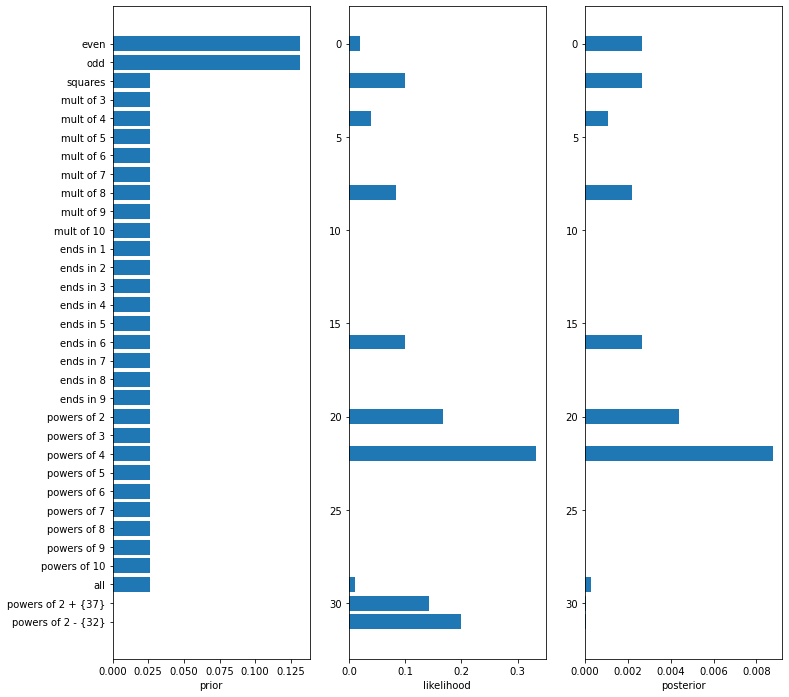

In [254]:
data = {16}

plot_hypothesis(hypotheses(), data, extension_limit)

Prior, likelihood and posterior for $\mathcal{D} = \{16, 8, 2, 64\}$.

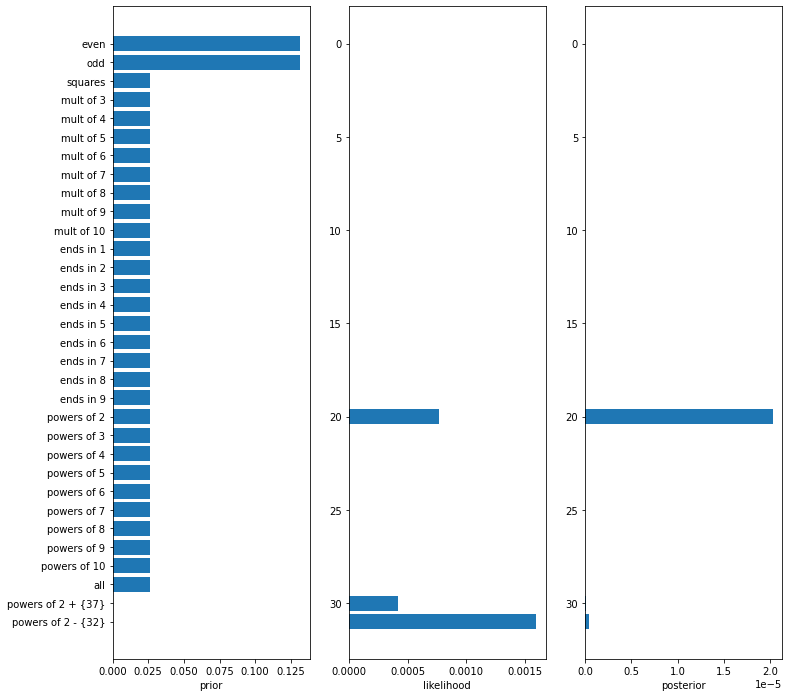

In [255]:
data = {16, 8 ,2, 64}

plot_hypothesis(hypotheses(), data, extension_limit)